In [ ]:
import torch
from torch import tensor
import triton
import triton.language as tl

from rk_triton.kernels.vec_add import vec_add

## Vector add

### Unit test

In [4]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

torch.manual_seed(37)
a = torch.randn(1000, device = DEVICE)
b = torch.randn(1000, device = DEVICE)

print(a[:10])
print(b[:10])


tensor([-1.5174, -0.0910, -0.0632,  1.1331,  0.6368,  0.3521, -0.9468,  0.9227,
        -0.4042, -0.2105], device='cuda:0')
tensor([-1.7416,  0.2004,  0.7647,  1.6015,  1.0685,  0.7661, -0.5468, -1.1853,
        -0.1594,  0.3170], device='cuda:0')


In [5]:
# unit test
triton_c = vec_add(a, b)
torch_c  = a + b
print(torch.max(torch.abs(triton_c - torch_c)))
assert torch.allclose(triton_c, torch_c)

tensor(0., device='cuda:0')


### Benchmark

#### 1. change block size

In [6]:
benchmark_config = triton.testing.Benchmark(
    x_names=['block_size'],
    x_vals=[2**i for i in range(10, 100)],
    x_log=True,
    line_arg='provider',
    line_vals=['triton', 'torch'], 
    line_names=['Triton', 'Torch'],
    styles=[('blue', '-'), ('green', '-')],
    ylabel='GB/s',
    plot_name='Throughput of vector add fucntions',
    args={},    
)

In [7]:
@triton.testing.perf_report(benchmark_config)
def benchmark(block_size, provider): # name of args should be aligned with
                                     # 'x_names' and 'line_arg' in 'benchmark_config' function
    x = torch.rand(10000, device=DEVICE, dtype=torch.float32)
    y = torch.rand(10000, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: vec_add(x, y, block_size), quantiles=quantiles)
    gb_per_s = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)


In [ ]:
benchmark.run(print_data=True, show_plots=True)


#### 2. change vector length

In [ ]:
benchmark_config = triton.testing.Benchmark(
    x_names=['vec_len'],
    x_vals=[2**i for i in range(6, 20)],
    x_log=True,
    line_arg='provider',
    line_vals=['triton', 'torch'], 
    line_names=['Triton', 'Torch'],
    styles=[('blue', '-'), ('green', '-')],
    ylabel='GB/s',
    plot_name='Throughput of vector add fucntions',
    args={},    
)

In [ ]:
@triton.testing.perf_report(benchmark_config)
def benchmark(vec_len, provider): # name of args should be aligned with
                                     # 'x_names' and 'line_arg' in 'benchmark_config' function
    x = torch.rand(vec_len, device=DEVICE, dtype=torch.float32)
    y = torch.rand(vec_len, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: vec_add(x, y), quantiles=quantiles)
    gb_per_s = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)

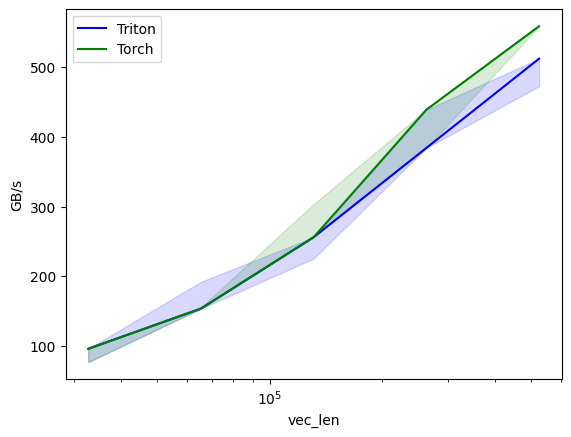

Throughput of vector add fucntions:
    vec_len      Triton       Torch
0   32768.0   96.000000   96.000000
1   65536.0  153.600004  153.600004
2  131072.0  255.999991  255.999991
3  262144.0  384.000001  438.857137
4  524288.0  511.999982  558.545450


In [ ]:
benchmark.run(print_data=True, show_plots=True)